<a href="https://colab.research.google.com/github/mambahuang/OpenCV_DL/blob/master/MNIST_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 121671 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.1) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


## python lib import

In [ ]:
from sys import int_info
from time import sleep

import numpy as np
import glob
import matplotlib.pyplot as plt

import os
import cv2
import pickle
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
# import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.transforms import v2

import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

import warnings

from tqdm import tqdm
from IPython.display import clear_output

## config set

In [ ]:
num_classes = 10
batch_size = 128
learning_rate = 0.00001
op = 'Adam'
epochs = 30
weight_decay = 1e-4
train_loss_epochs = []
train_acc_epochs = []
test_loss_epochs = []
test_acc_epochs = []

optimizers = {'SGD':torch.optim.SGD, 'Adam':torch.optim.Adam, 'RMSprop':torch.optim.RMSprop}

## DataSet loader

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

trainDataset = torchvision.datasets.MNIST(root = './', train = True, download = True, transform = transform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 0)
testDataset = torchvision.datasets.MNIST(root = './', train = False, download = True, transform = transform)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = True, num_workers = 0)


100%|██████████| 9912422/9912422 [00:00<00:00, 117258362.34it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40164354.72it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32730820.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20180644.88it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## model parameter set

In [ ]:
model = torchvision.models.vgg19_bn(num_classes=num_classes)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

if op == 'Adam':
    optimizer = optimizers[op](model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # optimizer = optimizers[op](model.parameters(), lr=learning_rate)
elif op == 'SGD':
    optimizer = optimizers[op](model.parameters(), lr=learning_rate, momentum=0.9)
else:
    print('optimizer未完成設置！\n')
    os._exit()

criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

## train model

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    acc_batch = 0.0
    model.train()  # 將model開啟訓練模式

    for i, data in tqdm(enumerate(trainLoader, 1)):
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        inputs = Variable(inputs)
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        acc_batch += (predicted == labels).sum().item()

    running_loss /= i
    acc_batch /= (i * batch_size)


    print("[%2d, %5d] Train Loss: %.3f" % (epoch + 1, i * batch_size, running_loss))
    print("[%2d, %5d] Train Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

    train_loss_epochs.append(running_loss)
    train_acc_epochs.append(acc_batch)

    model.eval()  # 將model開啟驗證模式
    running_loss = 0.0    # 歸零給test使用
    acc_batch = 0.0     # 歸零給test使用

    with torch.no_grad():
      for i, data in enumerate(testLoader, 1):
          inputs, labels = data
          if use_gpu:
              inputs = inputs.cuda()
              labels = labels.cuda()

          inputs = Variable(inputs, volatile=True)
          labels = Variable(labels, volatile=True)

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          num_correct = (predicted == labels).sum().item()

          running_loss += loss.item()
          acc_batch += num_correct

      running_loss /= i
      acc_batch /= (i * batch_size)
      test_loss_epochs.append(running_loss)
      test_acc_epochs.append(acc_batch)

    print("[%2d, %5d] Test Loss: %.3f" % (epoch + 1, i * batch_size, running_loss))
    print("[%2d, %5d] Test Accuracy: %.3f" % (epoch + 1, i * batch_size, acc_batch))

print(train_loss_epochs)
print(train_acc_epochs)
print(test_loss_epochs)
print(test_acc_epochs)
torch.save(model, './content/drive/MyDrive/NCKU_CV_DL/vgg19_20231215_v4.pth',_use_new_zipfile_serialization=False)

469it [01:27,  5.34it/s]
<ipython-input-7-a643b1b9e990>:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs, volatile=True)
<ipython-input-7-a643b1b9e990>:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  labels = Variable(labels, volatile=True)


[ 1, 60032] Train Loss: 0.599
[ 1, 60032] Train Accuracy: 0.800
[ 1, 10112] Test Loss: 0.110
[ 1, 10112] Test Accuracy: 0.953


469it [01:25,  5.46it/s]


[ 2, 60032] Train Loss: 0.086
[ 2, 60032] Train Accuracy: 0.973
[ 2, 10112] Test Loss: 0.084
[ 2, 10112] Test Accuracy: 0.963


469it [01:25,  5.49it/s]


[ 3, 60032] Train Loss: 0.029
[ 3, 60032] Train Accuracy: 0.991
[ 3, 10112] Test Loss: 0.089
[ 3, 10112] Test Accuracy: 0.965


469it [01:25,  5.46it/s]


[ 4, 60032] Train Loss: 0.012
[ 4, 60032] Train Accuracy: 0.996
[ 4, 10112] Test Loss: 0.089
[ 4, 10112] Test Accuracy: 0.966


469it [01:25,  5.51it/s]


[ 5, 60032] Train Loss: 0.009
[ 5, 60032] Train Accuracy: 0.997
[ 5, 10112] Test Loss: 0.077
[ 5, 10112] Test Accuracy: 0.969


469it [01:24,  5.52it/s]


[ 6, 60032] Train Loss: 0.008
[ 6, 60032] Train Accuracy: 0.997
[ 6, 10112] Test Loss: 0.080
[ 6, 10112] Test Accuracy: 0.969


469it [01:24,  5.52it/s]


[ 7, 60032] Train Loss: 0.013
[ 7, 60032] Train Accuracy: 0.995
[ 7, 10112] Test Loss: 0.093
[ 7, 10112] Test Accuracy: 0.967


469it [01:25,  5.51it/s]


[ 8, 60032] Train Loss: 0.012
[ 8, 60032] Train Accuracy: 0.996
[ 8, 10112] Test Loss: 0.092
[ 8, 10112] Test Accuracy: 0.969


469it [01:25,  5.46it/s]


[ 9, 60032] Train Loss: 0.009
[ 9, 60032] Train Accuracy: 0.996
[ 9, 10112] Test Loss: 0.077
[ 9, 10112] Test Accuracy: 0.972


469it [01:25,  5.51it/s]


[10, 60032] Train Loss: 0.008
[10, 60032] Train Accuracy: 0.997
[10, 10112] Test Loss: 0.087
[10, 10112] Test Accuracy: 0.972


469it [01:25,  5.50it/s]


[11, 60032] Train Loss: 0.007
[11, 60032] Train Accuracy: 0.997
[11, 10112] Test Loss: 0.080
[11, 10112] Test Accuracy: 0.972


469it [01:25,  5.51it/s]


[12, 60032] Train Loss: 0.008
[12, 60032] Train Accuracy: 0.997
[12, 10112] Test Loss: 0.102
[12, 10112] Test Accuracy: 0.968


469it [01:25,  5.48it/s]


[13, 60032] Train Loss: 0.011
[13, 60032] Train Accuracy: 0.996
[13, 10112] Test Loss: 0.081
[13, 10112] Test Accuracy: 0.973


469it [01:25,  5.46it/s]


[14, 60032] Train Loss: 0.007
[14, 60032] Train Accuracy: 0.997
[14, 10112] Test Loss: 0.081
[14, 10112] Test Accuracy: 0.973


469it [01:25,  5.50it/s]


[15, 60032] Train Loss: 0.007
[15, 60032] Train Accuracy: 0.997
[15, 10112] Test Loss: 0.079
[15, 10112] Test Accuracy: 0.974


469it [01:25,  5.48it/s]


[16, 60032] Train Loss: 0.006
[16, 60032] Train Accuracy: 0.998
[16, 10112] Test Loss: 0.077
[16, 10112] Test Accuracy: 0.974


469it [01:25,  5.46it/s]


[17, 60032] Train Loss: 0.004
[17, 60032] Train Accuracy: 0.998
[17, 10112] Test Loss: 0.078
[17, 10112] Test Accuracy: 0.975


469it [01:25,  5.48it/s]


[18, 60032] Train Loss: 0.005
[18, 60032] Train Accuracy: 0.998
[18, 10112] Test Loss: 0.072
[18, 10112] Test Accuracy: 0.975


469it [01:26,  5.43it/s]


[19, 60032] Train Loss: 0.007
[19, 60032] Train Accuracy: 0.998
[19, 10112] Test Loss: 0.077
[19, 10112] Test Accuracy: 0.974


469it [01:26,  5.43it/s]


[20, 60032] Train Loss: 0.004
[20, 60032] Train Accuracy: 0.998
[20, 10112] Test Loss: 0.067
[20, 10112] Test Accuracy: 0.977


469it [01:25,  5.46it/s]


[21, 60032] Train Loss: 0.006
[21, 60032] Train Accuracy: 0.998
[21, 10112] Test Loss: 0.083
[21, 10112] Test Accuracy: 0.974


469it [01:26,  5.44it/s]


[22, 60032] Train Loss: 0.004
[22, 60032] Train Accuracy: 0.998
[22, 10112] Test Loss: 0.075
[22, 10112] Test Accuracy: 0.975


469it [01:25,  5.50it/s]


[23, 60032] Train Loss: 0.003
[23, 60032] Train Accuracy: 0.998
[23, 10112] Test Loss: 0.090
[23, 10112] Test Accuracy: 0.974


469it [01:25,  5.48it/s]


[24, 60032] Train Loss: 0.005
[24, 60032] Train Accuracy: 0.998
[24, 10112] Test Loss: 0.061
[24, 10112] Test Accuracy: 0.978


469it [01:26,  5.42it/s]


[25, 60032] Train Loss: 0.005
[25, 60032] Train Accuracy: 0.998
[25, 10112] Test Loss: 0.065
[25, 10112] Test Accuracy: 0.975


469it [01:25,  5.46it/s]


[26, 60032] Train Loss: 0.006
[26, 60032] Train Accuracy: 0.998
[26, 10112] Test Loss: 0.075
[26, 10112] Test Accuracy: 0.976


469it [01:25,  5.46it/s]


[27, 60032] Train Loss: 0.007
[27, 60032] Train Accuracy: 0.998
[27, 10112] Test Loss: 0.070
[27, 10112] Test Accuracy: 0.975


469it [01:25,  5.47it/s]


[28, 60032] Train Loss: 0.004
[28, 60032] Train Accuracy: 0.999
[28, 10112] Test Loss: 0.066
[28, 10112] Test Accuracy: 0.976


469it [01:26,  5.45it/s]


[29, 60032] Train Loss: 0.001
[29, 60032] Train Accuracy: 0.999
[29, 10112] Test Loss: 0.071
[29, 10112] Test Accuracy: 0.976


469it [01:26,  5.43it/s]


[30, 60032] Train Loss: 0.003
[30, 60032] Train Accuracy: 0.999
[30, 10112] Test Loss: 0.075
[30, 10112] Test Accuracy: 0.977
[0.5985082538603846, 0.08601064502851351, 0.029202348553637136, 0.012025899386955802, 0.00869797163066203, 0.008093083912369806, 0.01291576238033654, 0.011634611994778523, 0.009214841645385014, 0.007949099963704334, 0.00684553829470125, 0.007864221584197738, 0.010913015602538463, 0.006562885207939986, 0.00688022208288612, 0.005886278536938969, 0.00447185650194363, 0.005105256396255107, 0.006956741281585694, 0.003929105115770389, 0.005760480215195733, 0.004076864371705933, 0.003324940967056768, 0.004675409890175256, 0.0052075964075370814, 0.0058338604345876946, 0.00681429418575871, 0.0036404480375591517, 0.0014746973343965114, 0.0025169845872573446]
[0.8000066631130064, 0.9732975746268657, 0.9905383795309168, 0.996035447761194, 0.9967517324093816, 0.9969016524520256, 0.9950026652452025, 0.9955856876332623, 0.9962519989339019, 0.9966684434968017, 0.997401385927505

In [ ]:
train_loss_epochs = [0.2657311481199285, 0.05641344205629247, 0.048137407138028235, 0.03736611756670879, 0.03412680764592487, 0.03225959448594918, 0.03333545279080249, 0.029644469786995104, 0.02955971545843432, 0.036072212044115634, 0.022216073923518008, 0.0323972591218342, 0.023708024304262103, 0.014894553566151436, 0.02803290037372247, 0.04897231318838229, 0.018261412398358223, 0.013516952776374469, 0.019118257554750374, 0.016887611277604648, 0.05053805700179331, 0.020506631094772593, 0.01739920226009611, 0.014179484017875551, 0.01786791895461174, 0.01388484663614541, 0.013635889718361233, 0.015731867324748024, 0.017524353739005506, 0.015178602883656288, 0.01610944605067598, 0.017953108314121054, 0.011012365947977559, 0.012980031392759587, 0.017517799452103095, 0.012826191314289394, 0.012329460329994602, 0.016497251142762345, 0.012923687704399958, 0.011477552029702414]
train_acc_epochs = [0.919809434968017, 0.984424973347548, 0.9874733475479744, 0.9907715884861408, 0.9911047441364605, 0.9916544509594882, 0.9918376865671642, 0.9924706823027718, 0.9927038912579957, 0.9919209754797441, 0.9944696162046909, 0.9928538113006397, 0.9939365671641791, 0.9962853144989339, 0.9932369402985075, 0.9897054904051172, 0.9955023987206824, 0.9963352878464818, 0.9950526385927505, 0.9956856343283582, 0.9906716417910447, 0.9952025586353944, 0.9957689232409381, 0.9964685501066098, 0.9954857409381663, 0.996168710021322, 0.9965018656716418, 0.9962853144989339, 0.9957522654584222, 0.9962519989339019, 0.9959521588486141, 0.9956856343283582, 0.9969349680170576, 0.9967850479744137, 0.9956856343283582, 0.9969183102345416, 0.9968683368869936, 0.99605210554371, 0.9967350746268657, 0.9968683368869936]
test_loss_epochs = [0.07550212065394543, 0.06395150303746326, 0.04517970797075312, 0.04800063735198324, 0.03806647832823705, 0.04376647795721464, 0.05133825213548173, 0.044051168486475945, 0.11142070633889753, 0.05966501585148935, 0.04834701571041789, 0.054795083091218506, 0.032870045988302884, 0.04402885954057845, 0.039680309855335695, 0.07592774544716548, 0.03141224349097752, 0.04150165109659392, 0.030817874736661723, 0.04578795021361542, 0.06194707719959861, 0.0374858303889308, 0.0325255209776791, 0.03908049642355948, 0.04062312304928657, 0.030518562345444283, 0.033001406026380235, 0.04805319102612159, 0.03834832476795897, 0.043288966924270034, 0.04857447831362819, 0.03839400752530068, 0.02888073006982302, 0.04340357859427392, 0.035175415588162624, 0.04098095314585879, 0.036861935748605947, 0.0304370523450485, 0.04149838428059446, 0.05329439768859088]
test_acc_epochs = [0.9685522151898734, 0.9717167721518988, 0.978243670886076, 0.9766613924050633, 0.9788370253164557, 0.9784414556962026, 0.9764636075949367, 0.9797270569620253, 0.9630142405063291, 0.9745846518987342, 0.9798259493670886, 0.9771558544303798, 0.9821993670886076, 0.9802215189873418, 0.9803204113924051, 0.9761669303797469, 0.982693829113924, 0.9812104430379747, 0.982693829113924, 0.9808148734177216, 0.9776503164556962, 0.982001582278481, 0.9829905063291139, 0.9812104430379747, 0.9814082278481012, 0.9837816455696202, 0.9832871835443038, 0.9783425632911392, 0.9817049050632911, 0.9799248417721519, 0.9799248417721519, 0.9822982594936709, 0.983682753164557, 0.979628164556962, 0.9817049050632911, 0.9803204113924051, 0.9806170886075949, 0.9825949367088608, 0.9811115506329114, 0.9794303797468354]


## 畫圖

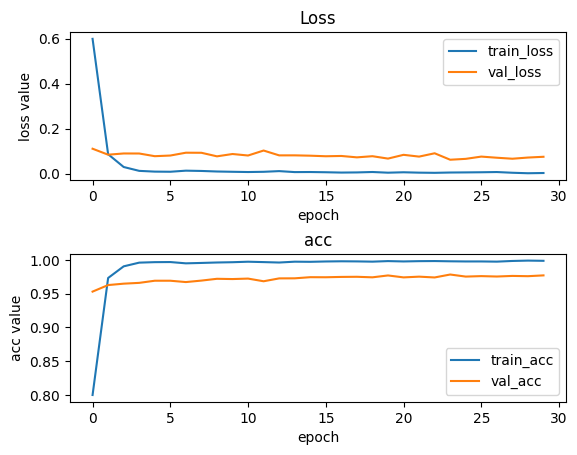

In [ ]:
# 畫圖

plt.subplot(2, 1, 1)
plt.plot(train_loss_epochs, label='train_loss')
plt.plot(test_loss_epochs, label='val_loss')
plt.title("Loss")  # 設定圖標題及其文字大小
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
# plt.savefig('./content/drive/MyDrive/NCKU_CV_DL/loss.png')
# plt.show()

plt.subplot(2, 1, 2)
plt.plot(train_acc_epochs, label='train_acc')
plt.plot(test_acc_epochs, label='val_acc')
plt.title("acc")  # 設定圖標題及其文字大小
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend()
# plt.savefig('./content/drive/MyDrive/NCKU_CV_DL/accuracy.png')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.savefig('./content/drive/MyDrive/NCKU_CV_DL/loss_accuracy_4.png')
plt.show()



